In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import itertools
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
params = {'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large',
         'figure.figsize': (12,5), "axes.labelsize":'x-large'}
plt.rcParams.update(params)

In [2]:
data = pd.read_pickle('res_age_randomized.p')
print(len(data))

3738


In [3]:
data['sample_size'] = data.g1t + data.g2t
data = data.rename(columns={'imbal':'imbalance'})
data.head()

,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbalance,ngrps,g1t,g2t,g1counts,g2counts,grouplabels,sample_size
NCT00000371,0.031798,27.0,28.0,1.610807,1.534536,0.000000,3,27,28,"[0.0, 0.0, 27.0]","[0.0, 0.0, 28.0]","[<=18 years, >=65 years, Between 18 and 65 years]",55
NCT00000378,2.981997,52.0,52.0,7.700000,4.400000,0.086278,3,58,52,"[0.0, 50.0, 8.0]","[0.0, 48.0, 4.0]","[<=18 years, >=65 years, Between 18 and 65 years]",110
NCT00000575,0.114583,307.0,306.0,9.600000,9.600000,0.000000,3,311,312,"[311.0, 0.0, 0.0]","[312.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]",623
NCT00001262,1.371846,22.0,35.0,1.652000,12.762000,0.000000,3,35,22,"[35.0, 0.0, 0.0]","[22.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]",57
NCT00001304,5.004346,14.0,13.0,0.020000,0.010000,0.168279,3,13,14,"[1.0, 0.0, 12.0]","[2.0, 1.0, 11.0]","[<=18 years, >=65 years, Between 18 and 65 years]",27


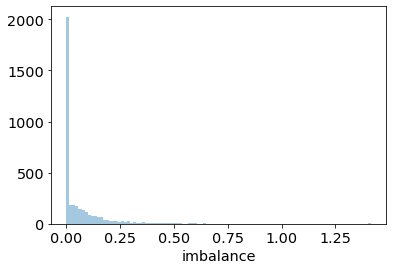

In [4]:
sns.distplot(data['imbalance'], kde=False, bins=100)

In [5]:
data.imbalance.describe(np.arange(0, 1, 0.05))

count    3738.000000
mean        0.063830
std         0.132089
min         0.000000
0%          0.000000
5%          0.000000
10%         0.000000
15%         0.000000
20%         0.000000
25%         0.000000
30%         0.000000
35%         0.000000
40%         0.000000
45%         0.000000
50%         0.001528
55%         0.016287
60%         0.030965
65%         0.044902
70%         0.061214
75%         0.079116
80%         0.103003
85%         0.136377
90%         0.178719
95%         0.282843
max         1.414214
Name: imbalance, dtype: float64

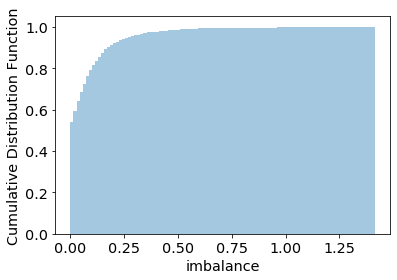

In [6]:
sns.distplot(
    data['imbalance'], kde=False, hist_kws={'cumulative': True}, norm_hist=True,
    bins=100
)
plt.ylabel('Cumulative Distribution Function')
plt.show()

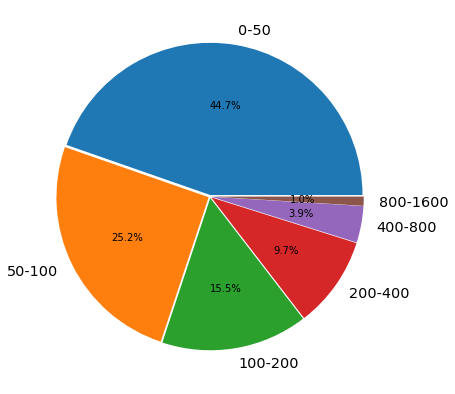

In [7]:
# trial size distribution
labels = []
shares = []

sample_sizes = [0, 50, 100, 200, 400, 800, 1600]
for i in range(len(sample_sizes)-1):
    lower, upper = sample_sizes[i:i+2]
    shares.append(
        data.sample_size.between(lower, upper).mean().round(2))
    labels.append('{}-{}'.format(lower, upper))    
    
plt.figure(figsize=(7, 7))
plt.pie(shares, explode=[.01] * len(shares), labels=labels, autopct='%.1f%%')
plt.show()

In [8]:
data.sample_size.describe()

count     3738.000000
mean       131.721776
std        385.122108
min          5.000000
25%         31.000000
50%         56.000000
75%        120.750000
max      16395.000000
Name: sample_size, dtype: float64

In [9]:
# ensure treatment and control groups are of similar sizes?
data = data.loc[np.log(data.g1t/data.g2t).abs() <= np.log(3)]
print(data.shape)

(3687, 13)


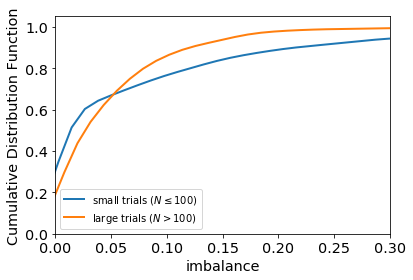

In [10]:
sns.distplot(
    data['imbalance'].loc[data.sample_size.between(0,100)], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": "small trials $(N \leq 100)$"}, 
    norm_hist=True, 
    bins=100
)
sns.distplot(
    data['imbalance'].loc[data.sample_size > 100], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": 'large trials $(N > 100)$'}, 
    norm_hist=True,
    bins=100
)
plt.xlim(0, .3)
plt.ylabel('Cumulative Distribution Function')
plt.show()

### Relative Imbalance was skipped, potentially it can be implementable if we look through the multi buckets

In [11]:
# additional variables

def average_sd(x):
    g1t, g2t, g1_sd_sample, g2_sd_sample = x
    return np.sqrt(g1t * g1_sd_sample **2 + g2t * g2_sd_sample ** 2) / np.sqrt(g1t + g2t)
    
data['average_sd'] = data[['g1t', 'g2t', 'g1_sd_sample', 'g2_sd_sample']].apply(
    average_sd, axis=1
)
data.head().T

,NCT00000371,NCT00000378,NCT00000575,NCT00001262,NCT00001304
effect,0.0317977,2.982,0.114583,1.37185,5.00435
g1_mean,27,52,307,22,14
g2_mean,28,52,306,35,13
g1_sd_sample,1.61081,7.7,9.6,1.652,0.02
g2_sd_sample,1.53454,4.4,9.6,12.762,0.01
imbalance,0,0.0862783,0,0,0.168279
ngrps,3,3,3,3,3
g1t,27,58,311,35,13
g2t,28,52,312,22,14
g1counts,"[0.0, 0.0, 27.0]","[0.0, 50.0, 8.0]","[311.0, 0.0, 0.0]","[35.0, 0.0, 0.0]","[1.0, 0.0, 12.0]"


In [12]:
data['signed_effect'] = (data['g1_mean'] - data['g2_mean']) / data['average_sd']
data['effect_size'] = data.signed_effect.abs()
data['bias'] = (1/data.g1t) + (1/data.g2t)
data['inverse_sample_size'] = 1/data.sample_size
data = data.loc[data.signed_effect.abs() < 3]

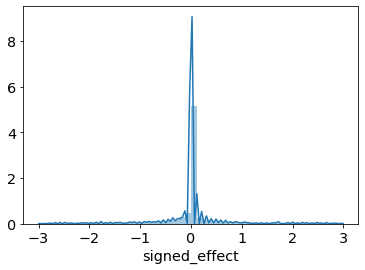

In [13]:
sns.distplot(data.signed_effect)

In [14]:
selected_data = data.copy()
selected_data = selected_data.loc[selected_data.imbalance.between(.02, .25)]

In [15]:
selected_data['residuals'] = np.square(selected_data.signed_effect
                                       - selected_data.signed_effect.mean()) - selected_data.bias
selected_data['square_imbalance'] = np.square(selected_data.imbalance)

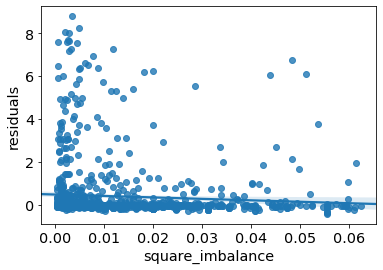

In [16]:
sns.regplot('square_imbalance', 'residuals', selected_data)

In [17]:
import matplotlib.ticker as mtick

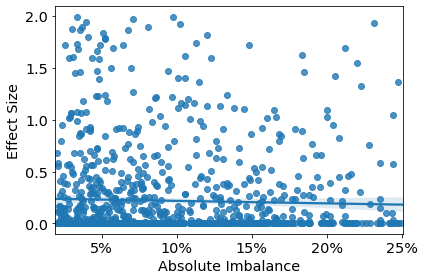

In [18]:
ax = sns.regplot('imbalance', 'effect_size', selected_data.loc[selected_data.effect_size <2])
plt.ylabel('Effect Size')
plt.xlabel('Absolute Imbalance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.xlim(0.019,.251)
plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_effect_size.pdf')
plt.show()

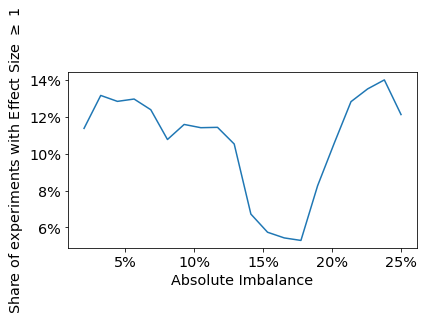

In [19]:
step = .025
share_large_effects = []

for imbalance in np.linspace(.02, .25, 20):
    is_large = (selected_data.loc[selected_data.imbalance.between(imbalance - step, imbalance + step)
                             ].effect_size >= 1)
    share_large_effects.append(is_large.mean())
    std_error = [is_large.std()]
share_large_effects

fig, ax = plt.subplots()
plt.plot(np.linspace(.02, .25, 20), share_large_effects)
plt.xlabel('Absolute Imbalance')
plt.ylabel('Share of experiments with Effect Size $\geq$ 1')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_large_effect_size.pdf')
plt.show()

In [20]:
mod = smf.ols('effect_size ~ imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.783
Date:                Sun, 27 Dec 2020   Prob (F-statistic):             0.0520
Time:                        17:52:07   Log-Likelihood:                -1074.7
No. Observations:                1185   AIC:                             2153.
Df Residuals:                    1183   BIC:                             2164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3665      0.034     10.717      0.0

In [21]:
mod = smf.ols('effect_size ~ imbalance + inverse_sample_size' , selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     9.653
Date:                Sun, 27 Dec 2020   Prob (F-statistic):           6.94e-05
Time:                        17:52:08   Log-Likelihood:                -1067.0
No. Observations:                1185   AIC:                             2140.
Df Residuals:                    1182   BIC:                             2155.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4055    

In [22]:
mod = smf.ols('residuals ~ square_imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.672
Date:                Sun, 27 Dec 2020   Prob (F-statistic):             0.0174
Time:                        17:52:08   Log-Likelihood:                -2021.1
No. Observations:                1185   AIC:                             4046.
Df Residuals:                    1183   BIC:                             4056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4659      0.052  

In [23]:
mod = smf.ols('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     16.86
Date:                Sun, 27 Dec 2020   Prob (F-statistic):           6.04e-08
Time:                        17:52:08   Log-Likelihood:                -2007.2
No. Observations:                1185   AIC:                             4020.
Df Residuals:                    1182   BIC:                             4036.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6503    

In [24]:
mod = smf.quantreg('residuals ~ square_imbalance', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:             0.003461
Model:                       QuantReg   Bandwidth:                     0.04497
Method:                 Least Squares   Sparsity:                       0.1694
Date:                Sun, 27 Dec 2020   No. Observations:                 1185
Time:                        17:52:09   Df Residuals:                     1183
                                        Df Model:                            1
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0194      0.003     -5.869      0.000      -0.026      -0.013
square_imbalance    -1.1680      0.180     -6.480      0.000      -1.522      -0.814


In [25]:
mod = smf.quantreg('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:              0.05650
Model:                       QuantReg   Bandwidth:                     0.03475
Method:                 Least Squares   Sparsity:                      0.07003
Date:                Sun, 27 Dec 2020   No. Observations:                 1185
Time:                        17:52:09   Df Residuals:                     1182
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0008      0.002      0.462      0.644      -0.002       0.004
square_imbalance     6.422e-06      0.080   8.06e-05      1.000      -0.156       0.156
inverse_sample_size    -4.0000      0.071    -56.053      0.000      -4.140      -3.860
